#  Homework 4 - Berkeley STAT 157

In this homework, we will build a model based real house sale data from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 

## Accessing and Reading Data Sets

The competition data is separated into training and test sets. Each record includes the property values of the house and attributes such as street type, year of construction, roof type, basement condition. The data includes multiple datatypes, including integers (year of construction), discrete labels (roof type), floating point numbers, etc.; Some data is missing and is thus labeled 'na'. The price of each house, namely the label, is only included in the training data set (it's a competition after all). The 'Data' tab on the competition tab has links to download the data.

In [1]:
# If pandas is not installed, please uncomment the following line:
# !pip install pandas

%matplotlib inline
import d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import numpy as np
import pandas as pd


#self-added
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt

We downloaded the data into the current directory. To load the two CSV (Comma Separated Values) files containing training and test data respectively we use Pandas.

In [3]:
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_train.csv')
utils.download('https://github.com/d2l-ai/d2l-en/raw/master/data/kaggle_house_pred_test.csv')
train_data = pd.read_csv('kaggle_house_pred_train.csv')
test_data = pd.read_csv('kaggle_house_pred_test.csv')

In [4]:
train_data.drop(train_data[(train_data['OverallQual']<5) & (train_data['SalePrice']>200000)].index,inplace=True)
train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<200000)].index,inplace=True)
train_data.drop(train_data[(train_data['YearBuilt']<1900) & (train_data['SalePrice']>400000)].index,inplace=True)
train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<200000)].index,inplace=True)

The training data set includes 1,460 examples, 80 features, and 1 label., the test data contains 1,459 examples and 80 features.

In [5]:
print(train_data.shape)
print(test_data.shape)

(1456, 81)
(1459, 80)


Let’s take a look at the first 4 and last 2 features as well as the label (SalePrice) from the first 4 examples:

In [6]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


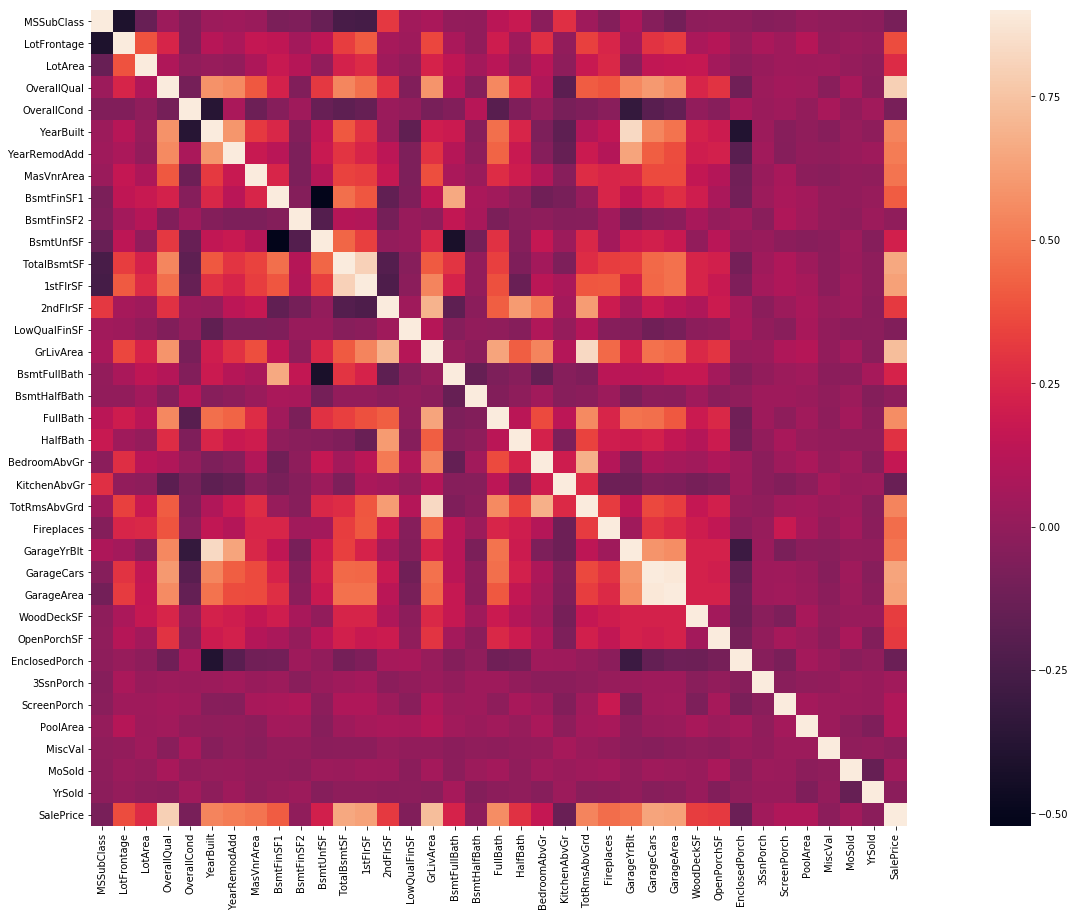

In [7]:
# correlation
corrmat = train_data.iloc[:, 1:].corr()
plt.subplots(figsize=(30,15))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [8]:
corrmat['SalePrice'].sort_values()

KitchenAbvGr    -0.135958
EnclosedPorch   -0.128153
OverallCond     -0.086731
MSSubClass      -0.085251
LowQualFinSF    -0.058163
YrSold          -0.025644
MiscVal         -0.021029
BsmtHalfBath    -0.016193
BsmtFinSF2      -0.010554
3SsnPorch        0.045167
MoSold           0.047491
ScreenPorch      0.095740
PoolArea         0.100196
BedroomAbvGr     0.166414
BsmtUnfSF        0.213042
BsmtFullBath     0.231127
LotArea          0.265330
HalfBath         0.283586
OpenPorchSF      0.314867
2ndFlrSF         0.316650
WoodDeckSF       0.327820
LotFrontage      0.370063
BsmtFinSF1       0.413509
Fireplaces       0.466798
MasVnrArea       0.487148
GarageYrBlt      0.489000
YearRemodAdd     0.509039
TotRmsAbvGrd     0.534152
YearBuilt        0.534649
FullBath         0.563970
GarageArea       0.628454
1stFlrSF         0.631967
GarageCars       0.640480
TotalBsmtSF      0.653743
GrLivArea        0.732257
OverallQual      0.796374
SalePrice        1.000000
Name: SalePrice, dtype: float64

### Highly correlated variables are the following pairs...
Variable Description:  https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data   
* YearBuilt - Garage Year Built   
* GrLivArea: Above grade (ground) living area square feet - TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)   
* Garage Cars - Garage Area    
* TotalBsmtSF: Total square feet of basement area - 1stFlrSF: First Floor square feet 
----------------------------------------------------------------------------------------------
<big>   
* Because of the correlation, ```all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond'], axis=1)```
     
* Considering the correlation between sales price, dropped 'LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch', 'PoolArea'

We can see that in each example, the first feature is the ID. This helps the model identify each training example. While this is convenient, it doesn't carry any information for prediction purposes. Hence we remove it from the dataset before feeding the data into the network.

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features = all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond'], axis=1)
all_features = all_features.drop(['LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', 'PoolArea'], axis=1)
all_features = all_features.reset_index(drop=True)
print(all_features.shape)
all_features.head(5)

(2915, 69)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,548.0,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,460.0,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,608.0,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,642.0,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,836.0,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,12,2008,WD,Normal


## Create YearsSinceRemodel and delete all 'Years' Variable ('YrSold','MoSold','YearBuilt','YearRemodAdd'）

In [7]:
all_features['YearsSinceRemodel'] = all_features['YrSold']- all_features['YearRemodAdd']
all_features = all_features.drop(['YrSold','MoSold','YearBuilt','YearRemodAdd'], 1)
print(all_features.shape)
all_features.head(5)

(2915, 66)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearsSinceRemodel
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,GasA,Ex,Y,SBrkr,856,854,1710,1.0,2,1,3,1,Gd,Typ,0,NaN,Attchd,RFn,548.0,TA,TA,Y,0,61,0,0,0,NaN,NaN,NaN,WD,Normal,5
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,GasA,Ex,Y,SBrkr,1262,0,1262,0.0,2,0,3,1,TA,Typ,1,TA,Attchd,RFn,460.0,TA,TA,Y,298,0,0,0,0,NaN,NaN,NaN,WD,Normal,31
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,GasA,Ex,Y,SBrkr,920,866,1786,1.0,2,1,3,1,Gd,Typ,1,TA,Attchd,RFn,608.0,TA,TA,Y,0,42,0,0,0,NaN,NaN,NaN,WD,Normal,6
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,GasA,Gd,Y,SBrkr,961,756,1717,1.0,1,0,3,1,Gd,Typ,1,Gd,Detchd,Unf,642.0,TA,TA,Y,0,35,272,0,0,NaN,NaN,NaN,WD,Abnorml,36
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,GasA,Ex,Y,SBrkr,1145,1053,2198,1.0,2,1,4,1,Gd,Typ,1,TA,Attchd,RFn,836.0,TA,TA,Y,192,84,0,0,0,NaN,NaN,NaN,WD,Normal,8


## Data Preprocessing

As stated above, we have a wide variety of datatypes. Before we feed it into a deep network we need to perform some amount of processing. Let's start with the numerical features. We begin by replacing missing values with the mean. This is a reasonable strategy if features are missing at random. To adjust them to a common scale we rescale them to zero mean and unit variance. This is accomplished as follows:

$$x \leftarrow \frac{x - \mu}{\sigma}$$

To check that this transforms $x$ to data with zero mean and unit variance simply calculate $\mathbf{E}[(x-\mu)/\sigma] = (\mu - \mu)/\sigma = 0$. To check the variance we use $\mathbf{E}[(x-\mu)^2] = \sigma^2$ and thus the transformed variable has unit variance. The reason for 'normalizing' the data is that it brings all features to the same order of magnitude. After all, we do not know *a priori* which features are likely to be relevant. Hence it makes sense to treat them equally.

### Missing Value   
<big>  
PoolQC, MiscFeature, Alley, Fence, FireplaceQu, LotFrontage should not be included in the model.(Could add a variale called 'missing')   
* Garage is missing for the same batch of data; GarageYearBuilt should not be included.  
* Basement is missing for the same batch of data;
* Masonry is missing for the same batch of data;   
* Solution to missing value:    
    1）mode/previous/after    
    2）delete the particular observations(What if there is only one observation?)
    
-------------------------------------------------------------------------------
The following code is to find those variable that has too many missing values. 

In [8]:
total = all_features.isnull().sum().sort_values(ascending=False)
percent = (all_features.isnull().sum()/all_features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(30)

,Total,Percent
PoolQC,2906,0.996913
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,485,0.166381
GarageFinish,159,0.054545
GarageCond,159,0.054545
GarageQual,159,0.054545
GarageType,157,0.053859


## Delete the first 6 features; 
* Create a Missing Class for variables like Garage and Basement; 
* If there is only one missing value or 2, delete the observation in the training set. Fill the missing value in testing set with mode.

In [9]:

def fill_missings(res):
    res['GarageType'] = res['GarageType'].fillna('missing')
    res['GarageFinish'] = res['GarageFinish'].fillna('missing')
    res['GarageQual'] = res['GarageQual'].fillna('missing')
    res['GarageCond'] = res['GarageCond'].fillna('missing')
    
    res['BsmtQual'] = res['BsmtQual'].fillna('missing')
    res['BsmtCond'] = res['BsmtCond'].fillna('missing')
    res['BsmtExposure'] = res['BsmtExposure'].fillna('missing')
    res['BsmtFinType1'] = res['BsmtFinType1'].fillna('missing')
    res['BsmtFinType2'] = res['BsmtFinType2'].fillna('missing')
    
    res['MSZoning'] = res['MSZoning'].fillna('missing')
    res['BsmtFullBath'] = res['BsmtFullBath'].fillna(res['BsmtFullBath'].mode()[0])
    res['Utilities'] = res['Utilities'].fillna('missing')
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0])   
    res['BsmtFinSF1'] = res['BsmtFinSF1'].fillna(0)
    res['BsmtUnfSF'] = res['BsmtUnfSF'].fillna(res['BsmtUnfSF'].mode()[0])
    
    res['Exterior1st'] = res['Exterior1st'].fillna(res['Exterior1st'].mode()[0])
    res['Exterior2nd'] = res['Exterior2nd'].fillna(res['Exterior2nd'].mode()[0]) 
    res["Functional"] = res["Functional"].fillna("Typ")
    res["Electrical"] = res["Electrical"].fillna(res["Electrical"].mode()[0])
    
    res['KitchenQual'] = res['KitchenQual'].fillna(res['KitchenQual'].mode()[0])
    res['SaleType'] = res['SaleType'].fillna(res['SaleType'].mode()[0])
    res['GarageArea'] = res['GarageArea'].fillna(0)
    
    #对Area用mean填充  
    #res['MasVnrArea'] = res['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    res['MasVnrArea'] = res['MasVnrArea'].fillna(0)
    res['MasVnrType'] = res['MasVnrType'].fillna('missing')
    


    return res
#mydata=fill_missings(my_data)

## Feature Engineering (e.g., one-hot...)

In [10]:
def map_values(full):
    
    full["oMSZoning"] = full.MSZoning.map({'missing': 0, 'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    full["oMasVnrType"] = full.MasVnrType.map({'missing':0, 'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFoundation"] = full.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'missing':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oBsmtExposure"] = full.BsmtExposure.map({'missing':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    
    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'missing':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    full["oGarageFinish"] = full.GarageFinish.map({'missing':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
    return "Done!"

In [11]:
def transform(X):

        #all_features = all_features.drop(['TotRmsAbvGrd', 'GarageCars', 'TotalBsmtSF','GarageYrBlt', 'OverallCond', 'BsmtUnfSF', 'EnclosedPorch'], axis=1)
        #all_features = all_features.drop(['LowQualFinSF','MiscVal', 'BsmtHalfBath', 'BsmtFinSF2', '3SsnPorch', 'PoolArea'], axis=1)
        X["TotalHouse"] =  X["1stFlrSF"] + X["2ndFlrSF"]   
        X["TotalArea"] =  X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]
            
        X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
        X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
        X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
        X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
        X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
        X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
        X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]
        
        X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
        X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
        X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
        X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
        X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
        X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]

        X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
        X["TotalPlace"] = X['BsmtUnfSF']+X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    
        return X

## Analyze the skewness (if greater than 0.15, need log-ize)

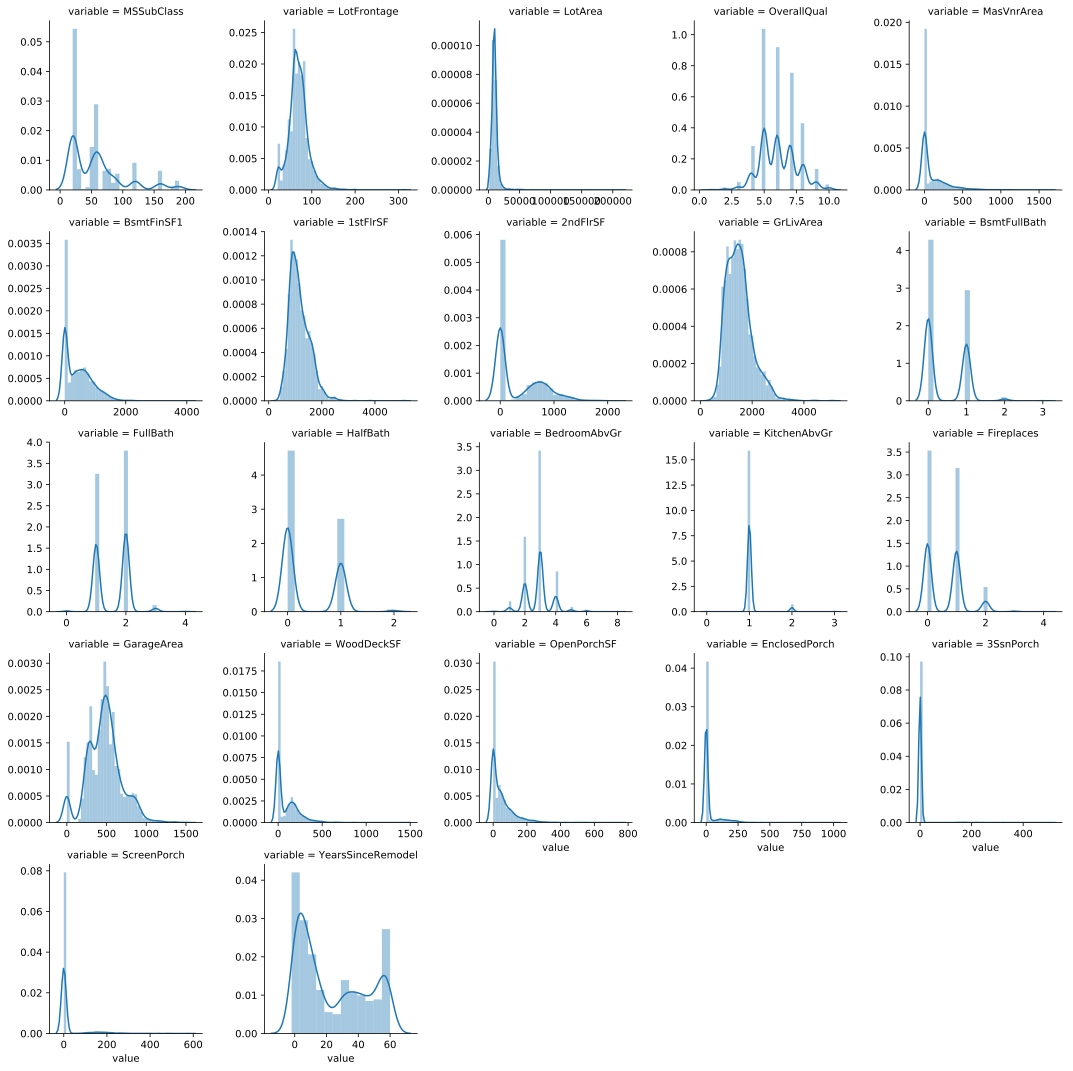

In [98]:
quantitative = [f for f in all_features.columns if all_features.dtypes[f] != 'object'and all_features.dtypes[f] != 'str']
skewed_feats = all_features[quantitative].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
f = pd.melt(all_features, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=5, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
plt.show()

In [ ]:
skewness.head(20)

In [12]:
all_features['LotArea'] = np.log1p(all_features['LotArea'] + 1.0)
all_features['3SsnPorch'] = np.log1p(all_features['3SsnPorch'] + 1.0)
all_features['KitchenAbvGr'] = np.log1p(all_features['KitchenAbvGr'] + 1.0)
all_features['EnclosedPorch'] = np.log1p(all_features['EnclosedPorch'] + 1.0)
all_features['ScreenPorch'] = np.log1p(all_features['ScreenPorch'] + 1.0)
all_features['MasVnrArea'] = np.log1p(all_features['MasVnrArea'] + 1.0)
all_features['OpenPorchSF'] = np.log1p(all_features['OpenPorchSF'] + 1.0)

## normalize

In [13]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# after standardizing the data all means vanish, hence we can set missing values to 0
#all_features = all_features.fillna(0)
print(all_features.shape)
all_features.head(5)

(2915, 66)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,YearsSinceRemodel
0,0.067175,RL,-0.183043,-0.100176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.650801,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.209366,Gd,TA,PConc,Gd,TA,No,GLQ,0.601388,Unf,-0.933965,GasA,Ex,Y,SBrkr,-0.782389,1.212243,0.428891,1.089452,0.782974,1.233636,0.170104,-0.204059,Gd,Typ,-0.924299,NaN,Attchd,RFn,0.352944,TA,TA,Y,-0.739813,0.818682,-0.426410,-0.112676,-0.308397,NaN,NaN,NaN,WD,Normal,-0.887840
1,-0.873119,RL,0.475068,0.151592,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,-0.061051,Gable,CompShg,MetalSd,MetalSd,None,-0.793521,TA,TA,CBlock,Gd,TA,Gd,ALQ,1.213886,Unf,-0.629175,GasA,Ex,Y,SBrkr,0.271541,-0.784666,-0.475191,-0.818890,0.782974,-0.755329,0.170104,-0.204059,TA,Typ,0.628630,TA,Attchd,RFn,-0.057152,TA,TA,Y,1.615152,-1.070005,-0.426410,-0.112676,-0.308397,NaN,NaN,NaN,WD,Normal,0.356462
2,0.067175,RL,-0.051421,0.464553,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,0.650801,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.127247,Gd,TA,PConc,Gd,TA,Mn,GLQ,0.105985,Unf,-0.287993,GasA,Ex,Y,SBrkr,-0.616252,1.240302,0.582262,1.089452,0.782974,1.233636,0.170104,-0.204059,Gd,Typ,0.628630,TA,Attchd,RFn,0.632555,TA,TA,Y,-0.739813,0.622178,-0.426410,-0.112676,-0.308397,NaN,NaN,NaN,WD,Normal,-0.839982
3,0.302249,RL,-0.402414,0.141288,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,0.650801,Gable,CompShg,Wd Sdng,Wd Shng,None,-0.793521,TA,TA,BrkTil,TA,Gd,No,ALQ,-0.502009,Unf,-0.046891,GasA,Gd,Y,SBrkr,-0.509821,0.983089,0.443018,1.089452,-1.026994,-0.755329,0.170104,-0.204059,Gd,Typ,0.628630,Gd,Detchd,Unf,0.791001,TA,TA,Y,-0.739813,0.527321,2.796612,-0.112676,-0.308397,NaN,NaN,NaN,WD,Abnorml,0.595751
4,0.067175,RL,0.650564,0.932398,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,1.362653,Gable,CompShg,VinylSd,VinylSd,BrkFace,1.460151,Gd,TA,PConc,Gd,TA,Av,GLQ,0.486544,Unf,-0.160619,GasA,Ex,Y,SBrkr,-0.032177,1.677564,1.413695,1.089452,0.782974,1.233636,1.385430,-0.204059,Gd,Typ,0.628630,TA,Attchd,RFn,1.695077,TA,TA,Y,0.777480,0.989054,-0.426410,-0.112676,-0.308397,NaN,NaN,NaN,WD,Normal,-0.744267


## Delete missing value

In [36]:
all_features2 = all_features.drop((missing_data[missing_data['Total'] >= 485]).index,1)
all_features2.shape

(2915, 60)

In [15]:
for index in (missing_data[missing_data['Total'] <5].index):
    print(all_features2.loc[all_features2[index].isnull()].index)

Int64Index([1911, 2212, 2246, 2900], dtype='int64')
Int64Index([2116, 2184], dtype='int64')
Int64Index([1911, 1941], dtype='int64')
Int64Index([2212, 2469], dtype='int64')
Int64Index([1551], dtype='int64')
Int64Index([1375], dtype='int64')
Int64Index([2147], dtype='int64')
Int64Index([2147], dtype='int64')
Int64Index([2485], dtype='int64')
Int64Index([2116], dtype='int64')
Int64Index([2572], dtype='int64')
Int64Index([2116], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([], d

In [100]:
all_features3 = all_features2.drop(1375)
all_features3.shape

(2914, 60)

In [101]:
all_features4 = fill_missings(all_features3)
all_features4.shape

(2914, 60)

In [102]:
all_features4.isnull().sum().max()

0

Next we deal with discrete values. This includes variables such as 'MSZoning'. We replace them by a one-hot encoding in the same manner as how we transformed multiclass classification data into a vector of $0$ and $1$. For instance, 'MSZoning' assumes the values 'RL' and 'RM'. They map into vectors $(1,0)$ and $(0,1)$ respectively. Pandas does this automatically for us.

In [103]:
map_values(all_features4)

transform(all_features4)
all_features4.head()
print(all_features4.shape)

(2914, 97)


In [104]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates an indicative feature for it.
# mli 是（2919，354）
all_features4 = pd.get_dummies(all_features4, dummy_na=True)
all_features4.shape

(2914, 342)

In [21]:
all_features4.head(5)

,MSSubClass,LotArea,OverallQual,MasVnrArea,BsmtFinSF1,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,YearsSinceRemodel,oMSZoning,oNeighborhood,oCondition1,oBldgType,oHouseStyle,oExterior1st,oMasVnrType,oExterQual,oFoundation,oBsmtQual,oBsmtExposure,oHeating,oHeatingQC,oKitchenQual,oFunctional,oGarageType,oGarageFinish,oPavedDrive,oSaleType,oSaleCondition,TotalHouse,TotalArea,+_TotalHouse_OverallQual,+_GrLivArea_OverallQual,+_oMSZoning_TotalHouse,+_oMSZoning_OverallQual,+_oNeighborhood_TotalHouse,+_oNeighborhood_OverallQual,+_BsmtFinSF1_OverallQual,-_oFunctional_TotalHouse,-_oFunctional_OverallQual,-_LotArea_OverallQual,-_TotalHouse_LotArea,-_oCondition1_TotalHouse,-_oCondition1_OverallQual,PorchArea,TotalPlace,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_missing,MSZoning_nan,Street_Grvl,Street_Pave,Street_nan,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_missing,Utilities_nan,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_missing,MasVnrType_nan,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_missing,BsmtQual_nan,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_missing,BsmtCond_nan,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_missing,BsmtExposure_nan,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,B

In [106]:
from sklearn.decomposition import PCA
pca = PCA(n_components=300)
all_features4 = pd.DataFrame(pca.fit_transform(all_features4))

In [109]:
all_features4.shape

(2914, 300)

## Log sales price.

You can see that this conversion increases the number of features from 79 to 331. Finally, via the `values` attribute we can extract the NumPy format from the Pandas dataframe and convert it into MXNet's native representation - NDArray for training.

In [23]:
n_train = train_data.shape[0]
train_features = nd.array(all_features4[:(n_train-1)].values)
test_features = nd.array(all_features4[(n_train-1):].values)
train_data2 = train_data.drop([1375])
#test_data2 = test_data.drop([455, 756, 790, 1444,660, 728,485,1013,691,1029,95,1116])


In [24]:
log = np.log(train_data2.SalePrice.values)
mean = np.mean(log)
std = np.std(log)

label = (log-mean)/std
#print(label)
train_labels = nd.array(label).reshape((-1, 1))
#print(train_labels)

## Training

To get started we train a linear model with squared loss. This will obviously not lead to a competition winning submission but it provides a sanity check to see whether there's meaningful information in the data. It also amounts to a minimum baseline of how well we should expect any 'fancy' model to work.

In [129]:
#loss = gloss.L2Loss()
def get_net(drop_prob1,drop_prob2):
    net = nn.Sequential()
    net.add(nn.Dense(32, activation="relu"),
            # Add a dropout layer after the first fully connected layer
            nn.Dropout(drop_prob1),
            #nn.Dense(64, activation="relu"),
            # Add a dropout layer after the second fully connected layer
            #nn.Dropout(drop_prob2),
            nn.Dense(1)
           )
    net.initialize(init.Normal(sigma=0.01))
    return net

In [86]:
#loss = gloss.L2Loss()

def get_net(drop_prob1,drop_prob2):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

House prices, like shares, are relative. That is, we probably care more about the relative error $\frac{y - \hat{y}}{y}$ than about the absolute error. For instance, getting a house price wrong by USD 100,000 is terrible in Rural Ohio, where the value of the house is USD 125,000. On the other hand, if we err by this amount in Los Altos Hills, California, we can be proud of the accuracy of our model (the median house price there exceeds 4 million).

One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. In fact, this is also the error that is being used to measure the quality in this competition. After all, a small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. This leads to the following loss function:

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [26]:
#log之后
def loss(train, labels):
    num_train = train.shape[0]
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    rmse = nd.sqrt((train -labels) ** 2/ num_train)
    return rmse

def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    #clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(net(features), labels).mean())
    return rmse.asscalar()

Unlike in the previous sections, the following training functions use the Adam optimization algorithm.  Compared to the previously used mini-batch stochastic gradient descent, the Adam optimization algorithm is relatively less sensitive to learning rates.  This will be covered in further detail later on when we discuss the details on [Optimization Algorithms](../chapter_optimization/index.md) in a separate chapter.

In [27]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        #train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
            #test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    return train_ls, test_ls

#log之后
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # The Adam optimization algorithm is used here.
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                #print(net(X))
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).asscalar())
        if test_labels is not None:
            test_ls.append(loss(net(test_features), test_labels).asscalar())
    return train_ls, test_ls

## k-Fold Cross-Validation

The k-fold cross-validation was introduced in the section where we discussed how to deal with [“Model Selection, Underfitting and Overfitting"](underfit-overfit.md). We will put this to good use to select the model design and to adjust the hyperparameters. We first need a function that returns the i-th fold of the data in a k-fold cros-validation procedure. It proceeds by slicing out the i-th segment as validation data and returning the rest as training data. Note - this is not the most efficient way of handling data and we would use something much smarter if the amount of data was considerably larger. But this would obscure the function of the code considerably and we thus omit it.

In [28]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [29]:

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size, drop_prob1,drop_prob2):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(drop_prob1,drop_prob2)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

# Model Selection

We pick a rather un-tuned set of hyperparameters and leave it up to the reader to improve the model considerably. Finding a good choice can take quite some time, depending on how many things one wants to optimize over. Within reason the k-fold crossvalidation approach is resilient against multiple testing. However, if we were to try out an unreasonably large number of options it might fail since we might just get lucky on the validation split with a particular set of hyperparameters.

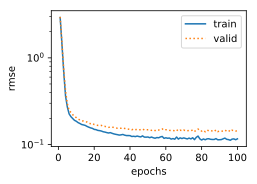

fold 0, train rmse: 0.116559, valid rmse: 0.145108
fold 1, train rmse: 0.111663, valid rmse: 0.148507
fold 2, train rmse: 0.111245, valid rmse: 0.158063
3-fold validation: avg train rmse: 0.113156, avg valid rmse: 0.150559


In [67]:
#不log的最好了
k, num_epochs, lr, weight_decay, batch_size = 3, 100, 0.1, 3000, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                        weight_decay, batch_size, 0.4, 0)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
              % (k, train_l, valid_l))

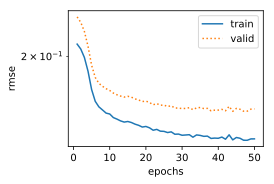

fold 0, train rmse: 0.111818, valid rmse: 0.138121
fold 1, train rmse: 0.112149, valid rmse: 0.141698
fold 2, train rmse: 0.105847, valid rmse: 0.139402
3-fold validation: avg train rmse: 0.109938, avg valid rmse: 0.139741


In [134]:
#log之后的
k, num_epochs, lr, weight_decay, batch_size = 3, 50, 0.0003, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                        weight_decay, batch_size, 0.4, 0)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
              % (k, train_l, valid_l))

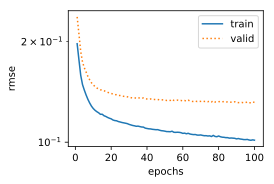

fold 0, train rmse: 0.101390, valid rmse: 0.131528
fold 1, train rmse: 0.100368, valid rmse: 0.132746
fold 2, train rmse: 0.098617, valid rmse: 0.135764
3-fold validation: avg train rmse: 0.100125, avg valid rmse: 0.133346


In [112]:
#log之后的
k, num_epochs, lr, weight_decay, batch_size = 3, 100, 0.00005, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                        weight_decay, batch_size, 0.8, 0)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
              % (k, train_l, valid_l))

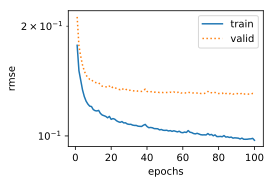

fold 0, train rmse: 0.097296, valid rmse: 0.130560
fold 1, train rmse: 0.096443, valid rmse: 0.133161
fold 2, train rmse: 0.094161, valid rmse: 0.136108
3-fold validation: avg train rmse: 0.095967, avg valid rmse: 0.133276


In [47]:
#log之后的
k, num_epochs, lr, weight_decay, batch_size = 3, 100, 0.0001, 0.0001, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                        weight_decay, batch_size, 0.8, 0)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
              % (k, train_l, valid_l))

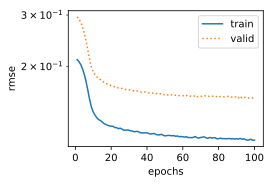

fold 0, train rmse: 0.111733, valid rmse: 0.155615
fold 1, train rmse: 0.111950, valid rmse: 0.164738
fold 2, train rmse: 0.111668, valid rmse: 0.163828
fold 3, train rmse: 0.111450, valid rmse: 0.159412
fold 4, train rmse: 0.110498, valid rmse: 0.168455
5-fold validation: avg train rmse: 0.111460, avg valid rmse: 0.162409


In [137]:
#after log sales
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.0001, 0.005, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                        weight_decay, batch_size, 0.4, 0)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
              % (k, train_l, valid_l))

You will notice that sometimes the number of training errors for a set of hyper-parameters can be very low, while the number of errors for the $K$-fold cross validation may be higher. This is most likely a consequence of overfitting. Therefore, when we reduce the amount of training errors, we need to check whether the amount of errors in the k-fold cross-validation have also been reduced accordingly.

##  Predict and Submit

Now that we know what a good choice of hyperparameters should be, we might as well use all the data to train on it (rather than just $1-1/k$ of the data that is used in the crossvalidation slices). The model that we obtain in this way can then be applied to the test set. Saving the estimates in a CSV file will simplify uploading the results to Kaggle.

In [ ]:
test_data['SalePrice'] = nd.exp(pd.Series(preds.reshape(1, -1)[0])) #need to exp back if using log price before

In [68]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size, drop_prob1,drop_prob2):
    net = get_net(drop_prob1,drop_prob2)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(test_features).asnumpy()
    # reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

In [68]:
#如果log了用这个
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size, drop_prob1,drop_prob2,mean,std):
    net = get_net(drop_prob1,drop_prob2)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    # apply the network to the test set
    preds = net(test_features).asnumpy()
    # reformat it for export to Kaggle
    test_data['SalePrice'] = np.expm1(pd.Series(preds.reshape(1, -1)[0])*std+mean)
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

Let's invoke the model. A good sanity check is to see whether the predictions on the test set resemble those of the k-fold crossvalication process. If they do, it's time to upload them to Kaggle.

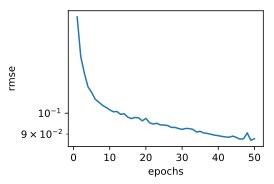

train rmse 0.087937


In [98]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,0.1,0,mean,std)

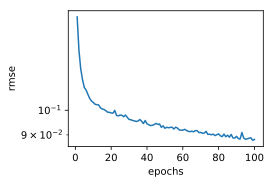

train rmse 0.088242


In [51]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,0.8,0,mean,std)

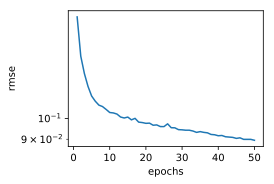

train rmse 0.089540


In [108]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,0.4,0,mean,std)

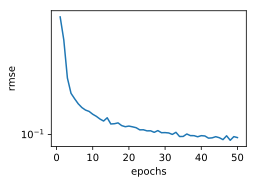

train rmse 0.098236


In [136]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size,0.4,0, mean, std)